<a href="https://colab.research.google.com/github/carlp1/AMDPiscitelli/blob/main/Linkedin_Market_Basket_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=147a180c9b2b3787ce68f593e60d17d139ca853a628015d64db01c28bfbdd8f1
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [2]:
import os
import zipfile
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, split, size, udf, array_contains, array_distinct, expr, size
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.fpm import FPGrowth
from collections import Counter
from itertools import combinations
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
os.environ['KAGGLE_USERNAME'] = 'carp12'
os.environ['KAGGLE_KEY'] = 'xxxx'

In [4]:
current_directory = os.getcwd()

zip_path = os.path.join(current_directory, '1-3m-linkedin-jobs-and-skills-2024.zip')
extract_path = os.path.join(current_directory, 'linkedin_dataset')

!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024 -p $current_directory

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)

Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
100% 1.87G/1.88G [00:09<00:00, 255MB/s]
100% 1.88G/1.88G [00:09<00:00, 207MB/s]


['linkedin_job_postings.csv', 'job_skills.csv', 'job_summary.csv']

In [5]:
spark = SparkSession.builder \
    .appName("FrequentItemsets") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "4") \
    .getOrCreate()

job_skills_path = os.path.join(extract_path, 'job_skills.csv')
df = spark.read.csv(job_skills_path, header=True, inferSchema=True)

In [6]:
df = df.select("job_skills")
null_count = df.filter(col("job_skills").isNull()).count()
print(f"Null values count: {null_count}")

Null values count: 2007


In [7]:
df = df.filter(col("job_skills").isNotNull())

In [8]:
df.printSchema()

root
 |-- job_skills: string (nullable = true)



In [9]:
def process_skills(job_skills):
    return [
        skill.strip().lower()
        for skill in job_skills.split(',')
        if 2 < len(skill.strip()) <= 20
    ]

process_skills_up = udf(process_skills, ArrayType(StringType()))

df = df.withColumn("job_skills", process_skills_up(col("job_skills")))
df = df.withColumn("job_skills", array_distinct(col("job_skills")))

df.show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|job_skills                                                                                                                                                                                                                                                                                                                                                                        |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
rdd = df.rdd.map(lambda row: row.job_skills)

In [11]:
support = 2000
first_pass = rdd.flatMap(lambda basket:[(e,1) for e in basket]) \
                .reduceByKey(lambda x,y:x+y) \
                .filter(lambda x:x[1]>support)

print("remaining singleton", first_pass.count())
print("5 random singleton", first_pass.take(5))

remaining singleton 1155
5 random singleton [('leadership', 183634), ('team collaboration', 15072), ('standards', 3718), ('revit', 7111), ('data collection', 11266)]


In [12]:
frequent_singletons = set(first_pass.map(lambda x:x[0]).collect())
second_pass = rdd.flatMap(lambda basket:[(e,1) for e in combinations(sorted(basket),2)]) \
                 .filter(lambda x: x[0][0] in frequent_singletons) \
                 .filter(lambda x: x[0][1] in frequent_singletons) \
                 .reduceByKey(lambda x,y: x+y) \
                 .filter(lambda x:x[1]>support)
print(second_pass.count())
print("5 random pairs", second_pass.take(5))

3763
5 random pairs [(('attention to detail', 'cleaning'), 2883), (('attention to detail', 'physical strength'), 4364), (('cost control', 'leadership'), 3453), (('high school diploma', 'scheduling'), 4900), (('leadership', 'training'), 35064)]


In [13]:
frequent_pairs = set(second_pass.map(lambda x:x[0]).collect())
third_pass = rdd.flatMap(lambda basket:[(e,1) for e in combinations(sorted(basket),3)]) \
                 .filter(lambda x: (x[0][0],x[0][1]) in frequent_pairs) \
                 .filter(lambda x: (x[0][1],x[0][2]) in frequent_pairs) \
                 .filter(lambda x: (x[0][0],x[0][2]) in frequent_pairs) \
                 .reduceByKey(lambda x,y: x+y) \
                 .filter(lambda x:x[1]>support)
print(third_pass.count())
print("5 random triplets", third_pass.take(5))

4638
5 random triplets [(("bachelor's degree", 'problemsolving', 'teamwork'), 2457), (('communication', 'high school diploma', 'training'), 3581), (('communication', 'problemsolving', 'teamwork'), 51228), (('customer service', 'high school diploma', 'scheduling'), 2793), (('customer service', 'leadership', 'problemsolving'), 18716)]


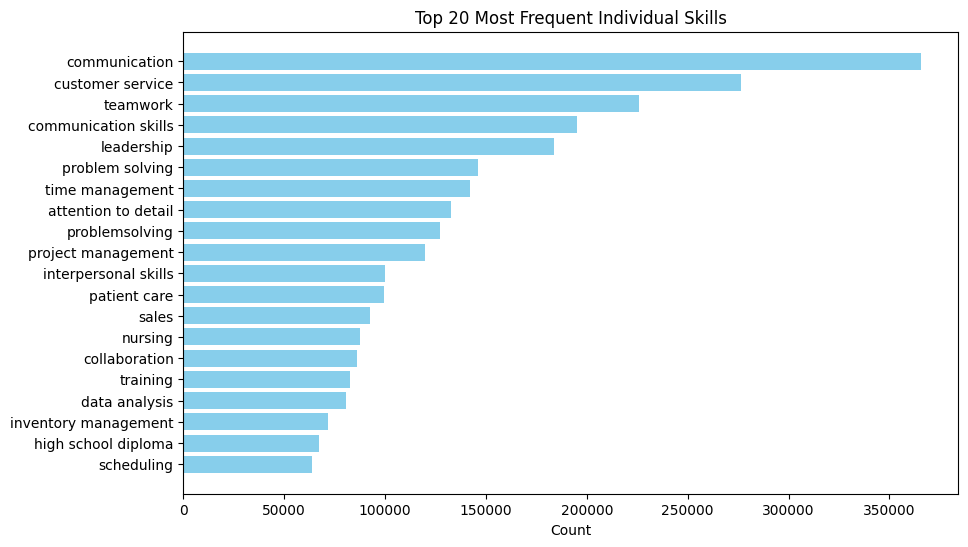

In [14]:
first_pass_data = first_pass.map(lambda x: (x[0], x[1])).collect()
df_first_pass = pd.DataFrame(first_pass_data, columns=['Skill', 'Count'])
df_first_pass = df_first_pass.sort_values(by='Count', ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(df_first_pass['Skill'].astype(str), df_first_pass['Count'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Most Frequent Individual Skills')
plt.gca().invert_yaxis()
plt.show()


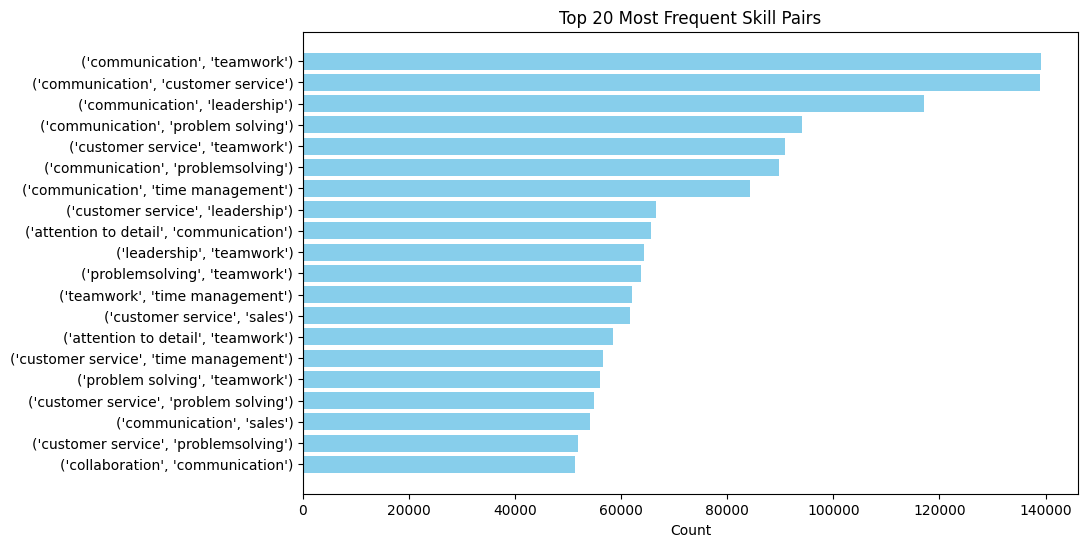

In [15]:
pair_data = second_pass.map(lambda x: (x[0], x[1])).collect()
df_pairs = pd.DataFrame(pair_data, columns=['Skill Pair', 'Count'])
df_pairs = df_pairs.sort_values(by='Count', ascending=False).head(20)
plt.figure(figsize=(10, 6))
plt.barh(df_pairs['Skill Pair'].astype(str), df_pairs['Count'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Most Frequent Skill Pairs')
plt.gca().invert_yaxis()
plt.show()


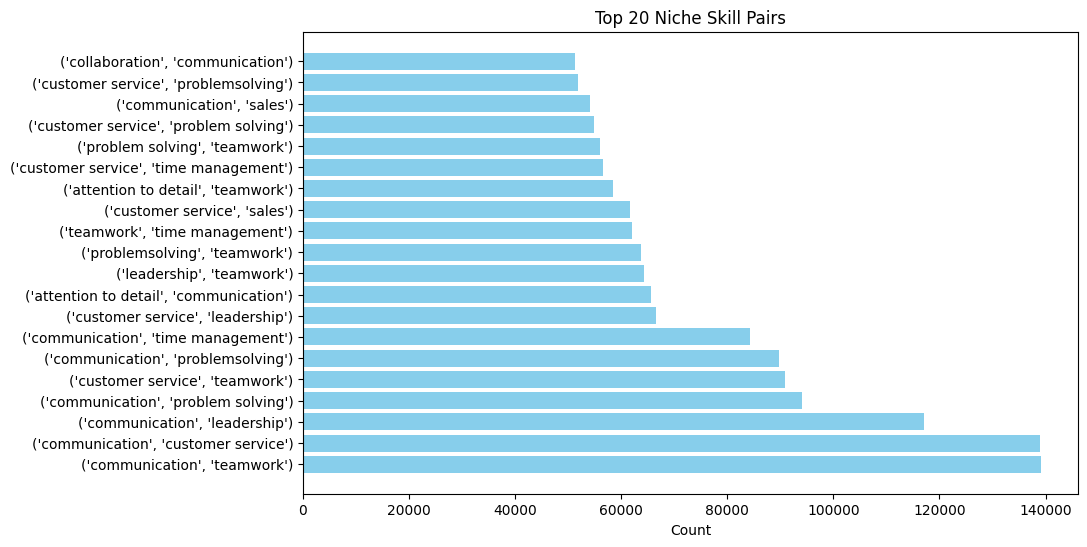

In [16]:
df_pairs = df_pairs.sort_values(by='Count', ascending=True).head(20)

plt.figure(figsize=(10, 6))
plt.barh(df_pairs['Skill Pair'].astype(str), df_pairs['Count'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Niche Skill Pairs')
plt.gca().invert_yaxis()
plt.show()

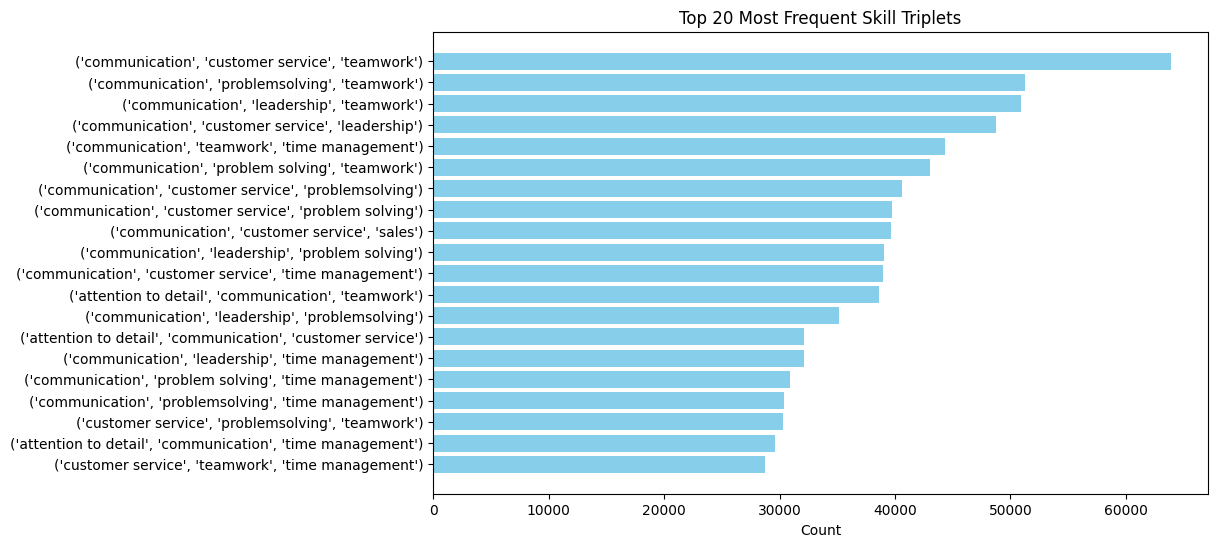

In [17]:
triplet_data = third_pass.map(lambda x: (x[0], x[1])).collect()
df_triplet = pd.DataFrame(triplet_data, columns=['Skill Triplets', 'Count'])
df_triplet = df_triplet.sort_values(by='Count', ascending=False).head(20)
plt.figure(figsize=(10, 6))
plt.barh(df_triplet['Skill Triplets'].astype(str), df_triplet['Count'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Most Frequent Skill Triplets')
plt.gca().invert_yaxis()
plt.show()

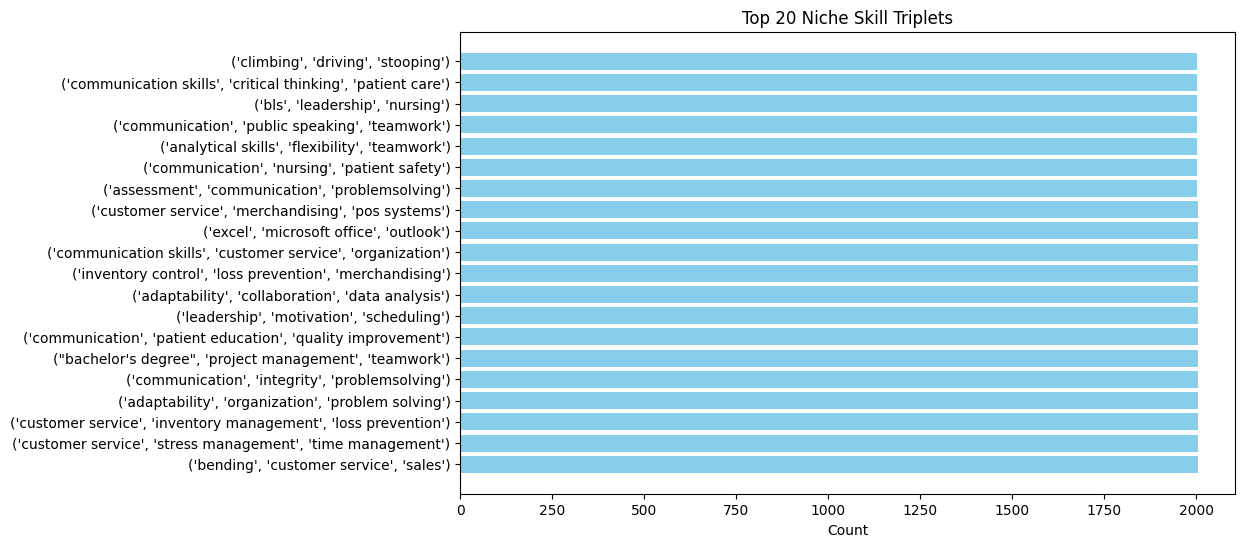

In [18]:
triplet_data_niche = third_pass.map(lambda x: (x[0], x[1])).collect()
df_niche_triplets = pd.DataFrame(triplet_data_niche, columns=['Skill Triplets', 'Count'])
df_niche_triplets = df_niche_triplets.sort_values(by='Count', ascending=True).head(20)
plt.figure(figsize=(10, 6))
plt.barh(df_niche_triplets['Skill Triplets'].astype(str), df_niche_triplets['Count'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Niche Skill Triplets')
plt.gca().invert_yaxis()
plt.show()

In [10]:
fp_growth = FPGrowth(itemsCol="job_skills", minSupport=0.0015)
model = fp_growth.fit(df)

In [11]:
frequent_itemsets = model.freqItemsets
frequent_itemsets.show(truncate=False)

+--------------------------------------------+-----+
|items                                       |freq |
+--------------------------------------------+-----+
|[group therapy]                             |2667 |
|[spreadsheets]                              |4013 |
|[risk analysis]                             |1992 |
|[public speaking]                           |10630|
|[public speaking, teamwork]                 |3029 |
|[public speaking, teamwork, communication]  |2002 |
|[public speaking, problem solving]          |2835 |
|[public speaking, collaboration]            |1943 |
|[public speaking, leadership]               |3488 |
|[public speaking, leadership, communication]|2373 |
|[public speaking, data analysis]            |2596 |
|[public speaking, customer service]         |2143 |
|[public speaking, project management]       |2609 |
|[public speaking, time management]          |2986 |
|[public speaking, communication]            |5097 |
|[ppe]                                       |

In [12]:
frequent_itemsets_with_size = frequent_itemsets.withColumn("num_items", size(frequent_itemsets["items"]))
frequent_itemsets_with_size.show(truncate=False)

+--------------------------------------------+-----+---------+
|items                                       |freq |num_items|
+--------------------------------------------+-----+---------+
|[group therapy]                             |2667 |1        |
|[spreadsheets]                              |4013 |1        |
|[risk analysis]                             |1992 |1        |
|[public speaking]                           |10630|1        |
|[public speaking, teamwork]                 |3029 |2        |
|[public speaking, teamwork, communication]  |2002 |3        |
|[public speaking, problem solving]          |2835 |2        |
|[public speaking, collaboration]            |1943 |2        |
|[public speaking, leadership]               |3488 |2        |
|[public speaking, leadership, communication]|2373 |3        |
|[public speaking, data analysis]            |2596 |2        |
|[public speaking, customer service]         |2143 |2        |
|[public speaking, project management]       |2609 |2  

In [13]:
singletons = frequent_itemsets_with_size.filter(frequent_itemsets_with_size["num_items"] == 1)
singletons.show(truncate=False)

+----------------------+-----+---------+
|items                 |freq |num_items|
+----------------------+-----+---------+
|[group therapy]       |2667 |1        |
|[spreadsheets]        |4013 |1        |
|[risk analysis]       |1992 |1        |
|[public speaking]     |10630|1        |
|[ppe]                 |3188 |1        |
|[production]          |5397 |1        |
|[google suite]        |4699 |1        |
|[confluence]          |2868 |1        |
|[counseling]          |16028|1        |
|[business strategy]   |2137 |1        |
|[bending]             |18639|1        |
|[sales targets]       |2316 |1        |
|[organized]           |2179 |1        |
|[hipaa compliance]    |4913 |1        |
|[writing]             |11817|1        |
|[staff development]   |5684 |1        |
|[excel]               |41355|1        |
|[entrepreneurship]    |2034 |1        |
|[community engagement]|3284 |1        |
|[pos system]          |2955 |1        |
+----------------------+-----+---------+
only showing top

In [14]:
pairs = frequent_itemsets_with_size.filter(frequent_itemsets_with_size["num_items"] == 2)
pairs.show(truncate=False)

+-------------------------------------+----+---------+
|items                                |freq|num_items|
+-------------------------------------+----+---------+
|[public speaking, teamwork]          |3029|2        |
|[public speaking, problem solving]   |2835|2        |
|[public speaking, collaboration]     |1943|2        |
|[public speaking, leadership]        |3488|2        |
|[public speaking, data analysis]     |2596|2        |
|[public speaking, customer service]  |2143|2        |
|[public speaking, project management]|2609|2        |
|[public speaking, time management]   |2986|2        |
|[public speaking, communication]     |5097|2        |
|[production, communication]          |1990|2        |
|[google suite, communication]        |1982|2        |
|[confluence, jira]                   |2636|2        |
|[counseling, teamwork]               |2802|2        |
|[counseling, problem solving]        |2018|2        |
|[counseling, collaboration]          |2555|2        |
|[counseli

In [15]:
triplets = frequent_itemsets_with_size.filter(frequent_itemsets_with_size["num_items"] == 3)
triplets.show(truncate=False)

+--------------------------------------------+----+---------+
|items                                       |freq|num_items|
+--------------------------------------------+----+---------+
|[public speaking, teamwork, communication]  |2002|3        |
|[public speaking, leadership, communication]|2373|3        |
|[bending, standing, cash handling]          |2332|3        |
|[bending, standing, teamwork]               |2455|3        |
|[bending, standing, lifting]                |9547|3        |
|[bending, standing, merchandising]          |1998|3        |
|[bending, standing, customer service]       |6069|3        |
|[bending, standing, high school diploma]    |2830|3        |
|[bending, standing, communication]          |4896|3        |
|[bending, cash handling, lifting]           |2431|3        |
|[bending, cash handling, customer service]  |2430|3        |
|[bending, teamwork, customer service]       |2027|3        |
|[bending, teamwork, communication]          |2648|3        |
|[bendin

In [16]:
top_20_singletons = singletons.orderBy(col("freq").desc()).limit(20)
top_20_pairs = pairs.orderBy(col("freq").desc()).limit(20)
top_20_triplets = triplets.orderBy(col("freq").desc()).limit(20)
bottom_20_singletons = singletons.orderBy(col("freq")).limit(20)
bottom_20_pairs = pairs.orderBy(col("freq")).limit(20)
bottom_20_triplets = triplets.orderBy(col("freq")).limit(20)

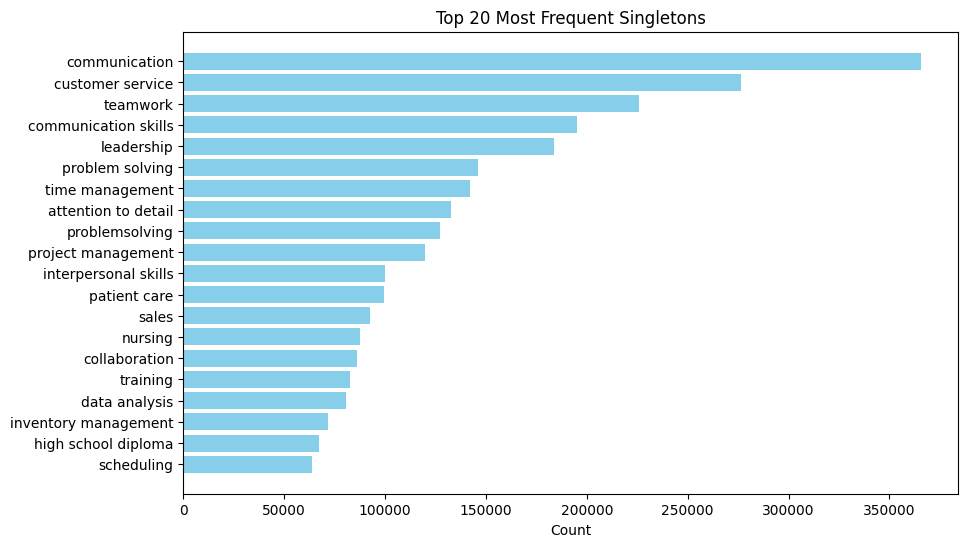

In [20]:
top_20_singletons_2 = top_20_singletons.limit(20).select("items", "freq").toPandas()

top_20_singletons_2["items"] = top_20_singletons_2["items"].apply(lambda x: ', '.join(x))

plt.figure(figsize=(10, 6))
plt.barh(top_20_singletons_2['items'], top_20_singletons_2['freq'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Most Frequent Singletons')
plt.gca().invert_yaxis()
plt.show()

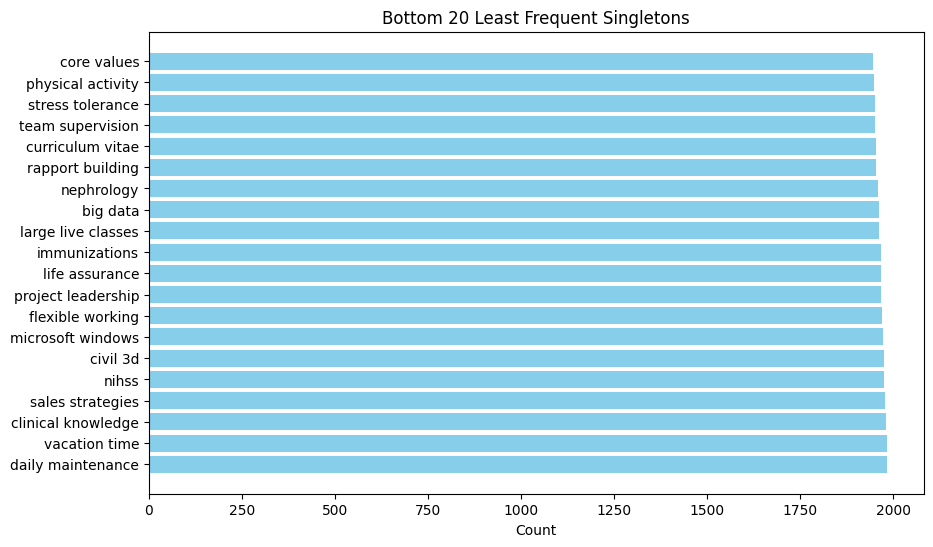

In [21]:
bottom_20_singletons2 = bottom_20_singletons.select("items", "freq").toPandas()
bottom_20_singletons2["items"] = bottom_20_singletons2["items"].apply(lambda x: ', '.join(x))

plt.figure(figsize=(10, 6))
plt.barh(bottom_20_singletons2['items'], bottom_20_singletons2['freq'], color='skyblue')
plt.xlabel('Count')
plt.title('Bottom 20 Least Frequent Singletons')
plt.gca().invert_yaxis()
plt.show()

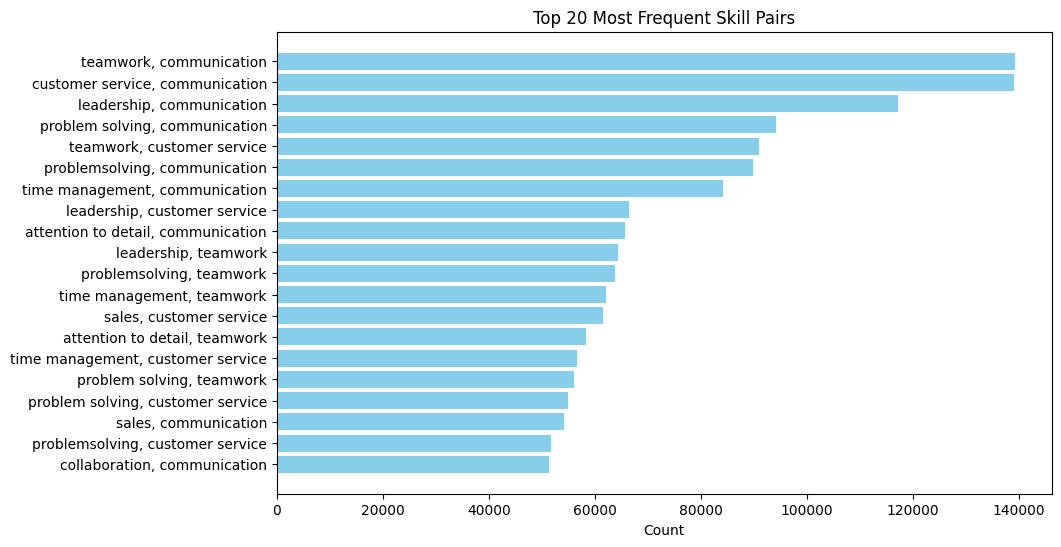

In [22]:
top_20_pairs2 = top_20_pairs.select("items", "freq").toPandas()
top_20_pairs2["items"] = top_20_pairs2["items"].apply(lambda x: ', '.join(x))

plt.figure(figsize=(10, 6))
plt.barh(top_20_pairs2['items'], top_20_pairs2['freq'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Most Frequent Skill Pairs')
plt.gca().invert_yaxis()
plt.show()

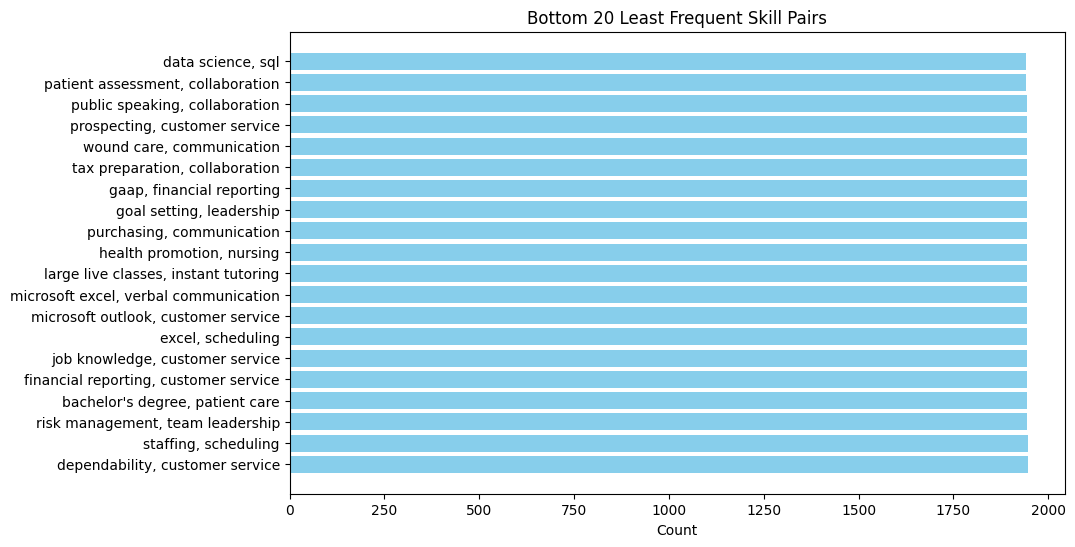

In [23]:
bottom_20_pairs2 = bottom_20_pairs.select("items", "freq").toPandas()
bottom_20_pairs2["items"] = bottom_20_pairs2["items"].apply(lambda x: ', '.join(x))

plt.figure(figsize=(10, 6))
plt.barh(bottom_20_pairs2['items'], bottom_20_pairs2['freq'], color='skyblue')
plt.xlabel('Count')
plt.title('Bottom 20 Least Frequent Skill Pairs')
plt.gca().invert_yaxis()
plt.show()

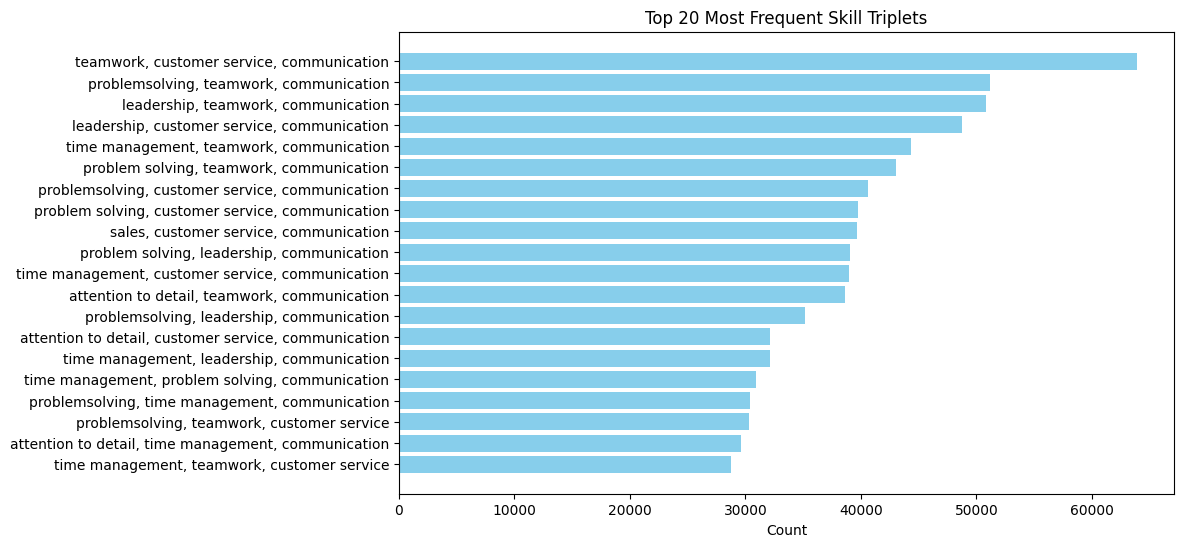

In [24]:
top_20_triplets2 = top_20_triplets.select("items", "freq").toPandas()
top_20_triplets2["items"] = top_20_triplets2["items"].apply(lambda x: ', '.join(x))

plt.figure(figsize=(10, 6))
plt.barh(top_20_triplets2['items'], top_20_triplets2['freq'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Most Frequent Skill Triplets')
plt.gca().invert_yaxis()
plt.show()

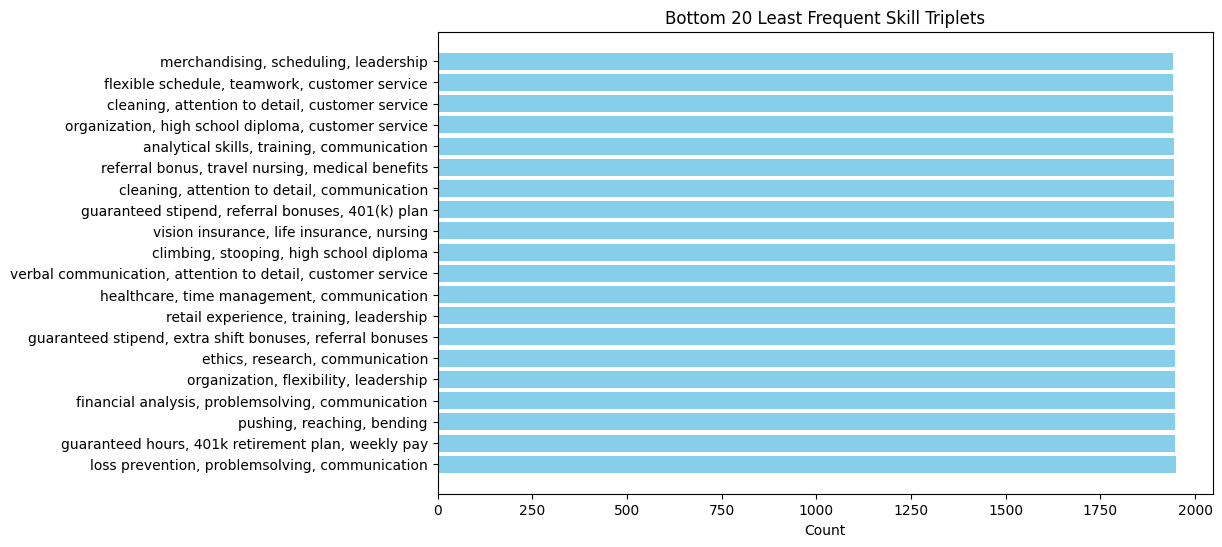

In [25]:
bottom_20_triplets2 = bottom_20_triplets.select("items", "freq").toPandas()
bottom_20_triplets2["items"] = bottom_20_triplets2["items"].apply(lambda x: ', '.join(x))

plt.figure(figsize=(10, 6))
plt.barh(bottom_20_triplets2['items'], bottom_20_triplets2['freq'], color='skyblue')
plt.xlabel('Count')
plt.title('Bottom 20 Least Frequent Skill Triplets')
plt.gca().invert_yaxis()
plt.show()

In [26]:
num_singletons = singletons.count()
num_pairs = pairs.count()
num_triplets = triplets.count()

print(f"Number of Singletons: {num_singletons}")
print(f"Number of Pairs: {num_pairs}")
print(f"Number of Triplets: {num_triplets}")

Number of Singletons: 1190
Number of Pairs: 3927
Number of Triplets: 4885


In [12]:
quadruplets = frequent_itemsets_with_size.filter(frequent_itemsets_with_size["num_items"] == 4)
quadruplets.show(truncate=False)

+-----------------------------------------------------------------+-----+---------+
|items                                                            |freq |num_items|
+-----------------------------------------------------------------+-----+---------+
|[bending, standing, cash handling, lifting]                      |2182 |4        |
|[bending, standing, cash handling, customer service]             |2138 |4        |
|[bending, standing, lifting, teamwork]                           |2068 |4        |
|[bending, standing, lifting, customer service]                   |5391 |4        |
|[bending, standing, lifting, high school diploma]                |2514 |4        |
|[bending, standing, lifting, communication]                      |4221 |4        |
|[bending, standing, customer service, communication]             |3046 |4        |
|[bending, standing, high school diploma, customer service]       |2140 |4        |
|[bending, cash handling, lifting, customer service]              |2242 |4  

In [13]:
quintuplets = frequent_itemsets_with_size.filter(frequent_itemsets_with_size["num_items"] == 5)
quintuplets.show(truncate=False)

+---------------------------------------------------------------------------------------+-----+---------+
|items                                                                                  |freq |num_items|
+---------------------------------------------------------------------------------------+-----+---------+
|[bending, standing, cash handling, lifting, customer service]                          |2033 |5        |
|[bending, standing, lifting, customer service, communication]                          |2795 |5        |
|[bending, standing, lifting, high school diploma, customer service]                    |1990 |5        |
|[problemsolving, leadership, teamwork, customer service, communication]                |10438|5        |
|[problemsolving, attention to detail, teamwork, customer service, communication]       |10465|5        |
|[problemsolving, attention to detail, leadership, teamwork, customer service]          |4268 |5        |
|[problemsolving, attention to detail, leaders

In [15]:
sextuplets = frequent_itemsets_with_size.filter(frequent_itemsets_with_size["num_items"] == 46)
sextuplets.show(truncate=False)

+-----+----+---------+
|items|freq|num_items|
+-----+----+---------+
+-----+----+---------+



In [17]:
num_quadruplets = quadruplets.count()
num_quintuplets = quintuplets.count()
num_sextuplets = sextuplets.count()

print(f"Number of quadruplets: {num_quadruplets}")
print(f"Number of quintuplets: {num_quintuplets}")
print(f"Number of sextuplets: {num_sextuplets}")

Number of quadruplets: 3104
Number of quintuplets: 1101
Number of sextuplets: 0


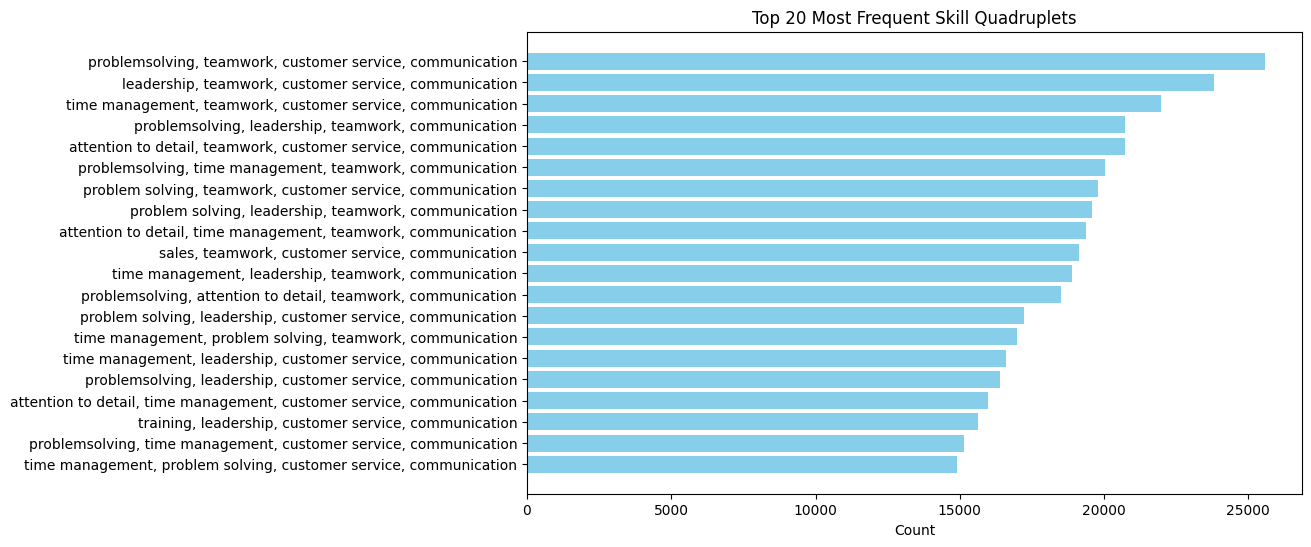

In [20]:
top_20_quadruplets = quadruplets.orderBy(col("freq").desc()).limit(20)
bottom_20_quadruplets = quadruplets.orderBy(col("freq")).limit(20)
top_20_quadruplets2 = top_20_quadruplets.select("items", "freq").toPandas()
top_20_quadruplets2["items"] = top_20_quadruplets2["items"].apply(lambda x: ', '.join(x))

plt.figure(figsize=(10, 6))
plt.barh(top_20_quadruplets2['items'], top_20_quadruplets2['freq'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Most Frequent Skill Quadruplets')
plt.gca().invert_yaxis()
plt.show()

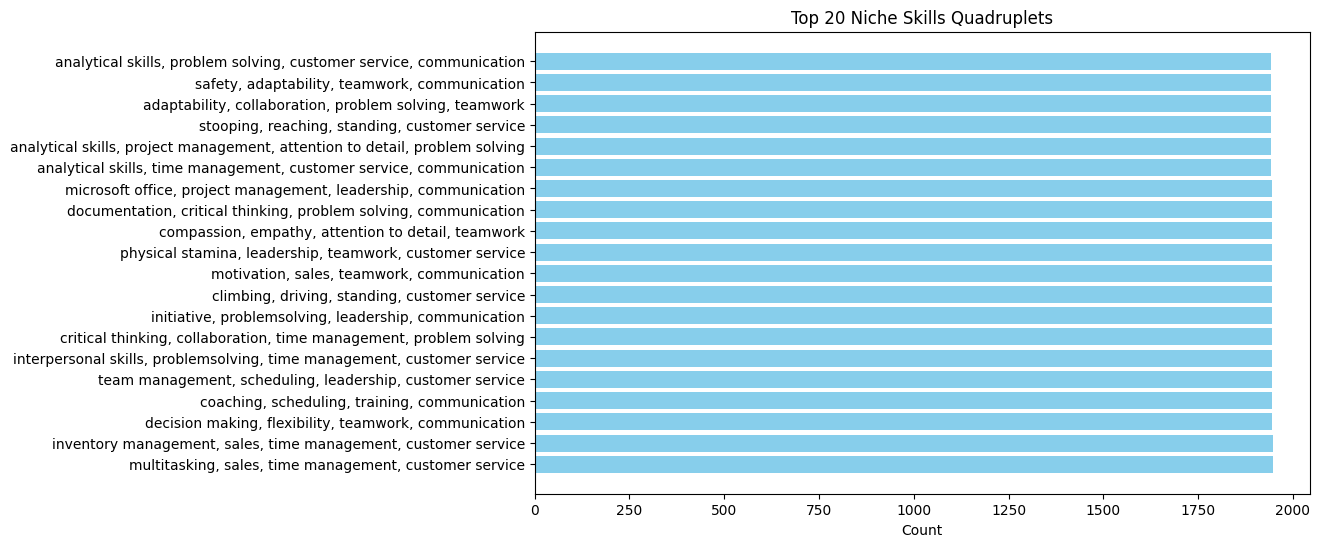

In [21]:
bottom_20_quadruplets2 = bottom_20_quadruplets.select("items", "freq").toPandas()
bottom_20_quadruplets2["items"] = bottom_20_quadruplets2["items"].apply(lambda x: ', '.join(x))

plt.figure(figsize=(10, 6))
plt.barh(bottom_20_quadruplets2['items'], bottom_20_quadruplets2['freq'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Niche Skills Quadruplets')
plt.gca().invert_yaxis()
plt.show()

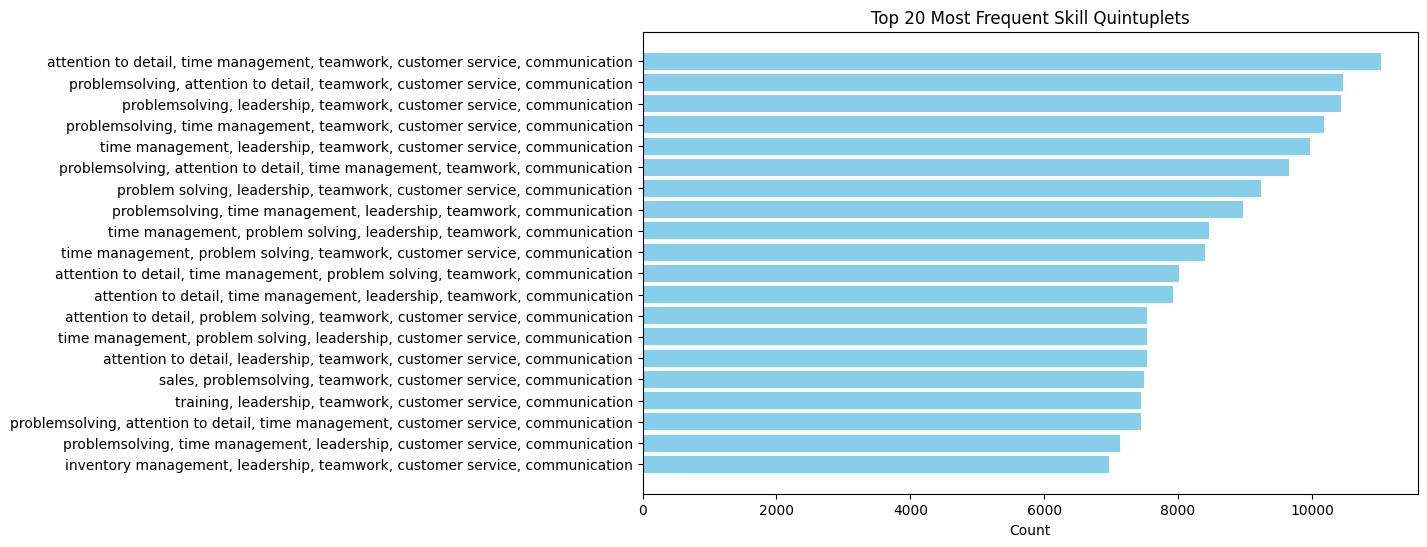

In [15]:
top_20_quintuplets = quintuplets.orderBy(col("freq").desc()).limit(20)
bottom_20_quintuplets = quintuplets.orderBy(col("freq")).limit(20)
top_20_quintuplets2 = top_20_quintuplets.select("items", "freq").toPandas()
top_20_quintuplets2["items"] = top_20_quintuplets2["items"].apply(lambda x: ', '.join(x))

plt.figure(figsize=(10, 6))
plt.barh(top_20_quintuplets2['items'], top_20_quintuplets2['freq'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Most Frequent Skill Quintuplets')
plt.gca().invert_yaxis()
plt.show()

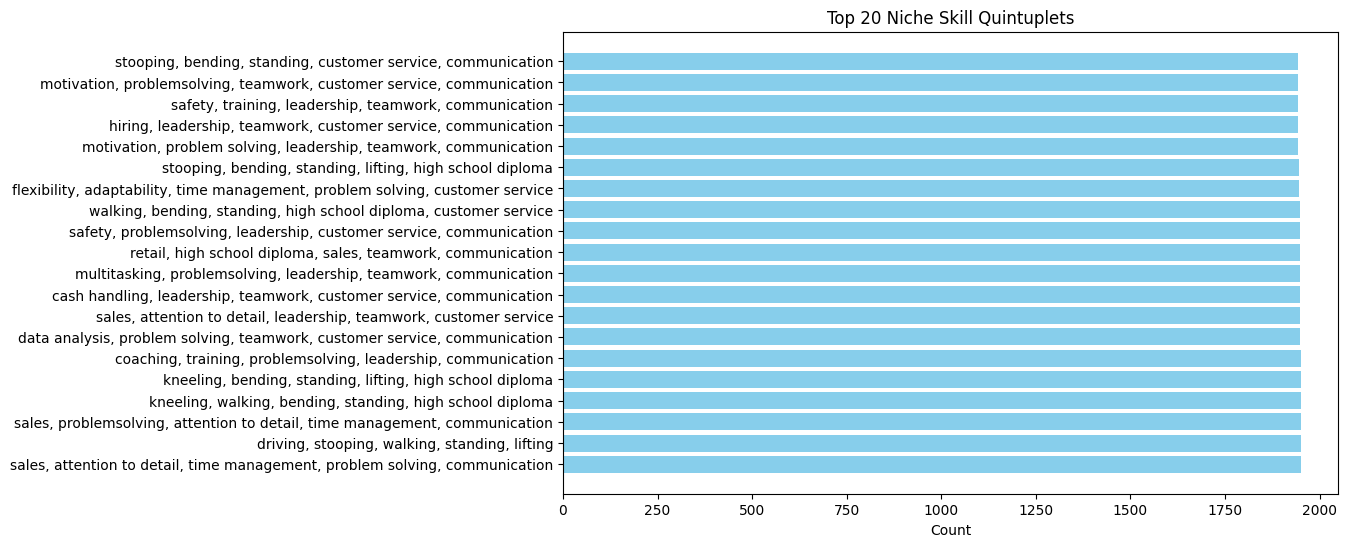

In [16]:
bottom_20_quintuplets2 = bottom_20_quintuplets.select("items", "freq").toPandas()
bottom_20_quintuplets2["items"] = bottom_20_quintuplets2["items"].apply(lambda x: ', '.join(x))

plt.figure(figsize=(10, 6))
plt.barh(bottom_20_quintuplets2['items'], bottom_20_quintuplets2['freq'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Niche Skill Quintuplets')
plt.gca().invert_yaxis()
plt.show()

In [14]:
target_skills = ["data", "data analysis", "data analytics", "big data", "machine learning"]

target_conditions = " OR ".join([f"array_contains(items, '{skill}')" for skill in target_skills])

In [27]:
filtered_pairs = pairs.filter(expr(target_conditions))
top_20_filtered_pairs = filtered_pairs.orderBy(col("freq").desc()).limit(20)

filtered_triplets = triplets.filter(expr(target_conditions))
top_20_filtered_triplets = filtered_triplets.orderBy(col("freq").desc()).limit(20)

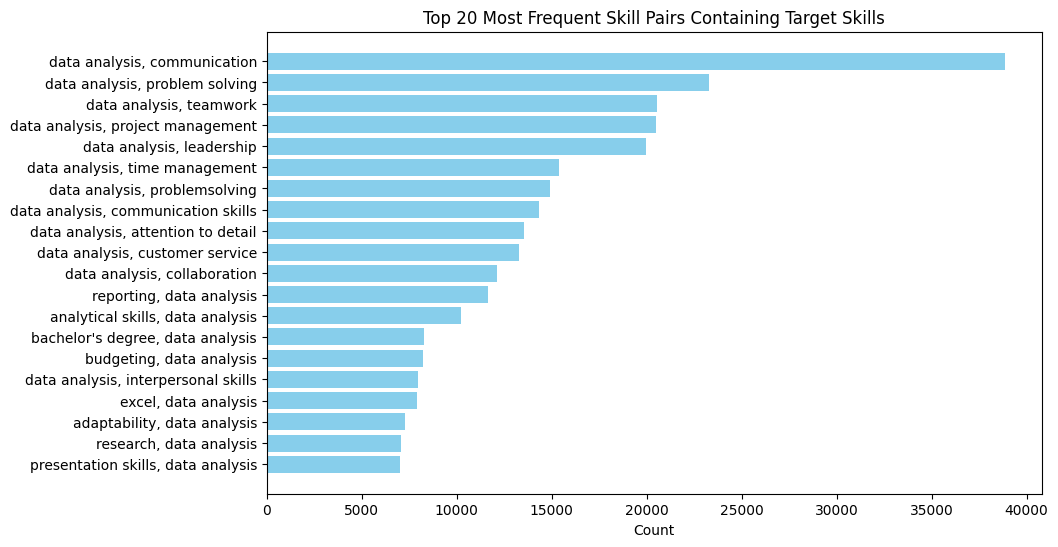

In [28]:
top_20_filtered_pairs_df = top_20_filtered_pairs.toPandas()
top_20_filtered_pairs_df["items"] = top_20_filtered_pairs_df["items"].apply(lambda x: ', '.join(x))

plt.figure(figsize=(10, 6))
plt.barh(top_20_filtered_pairs_df['items'], top_20_filtered_pairs_df['freq'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Most Frequent Skill Pairs Containing Target Skills')
plt.gca().invert_yaxis()
plt.show()

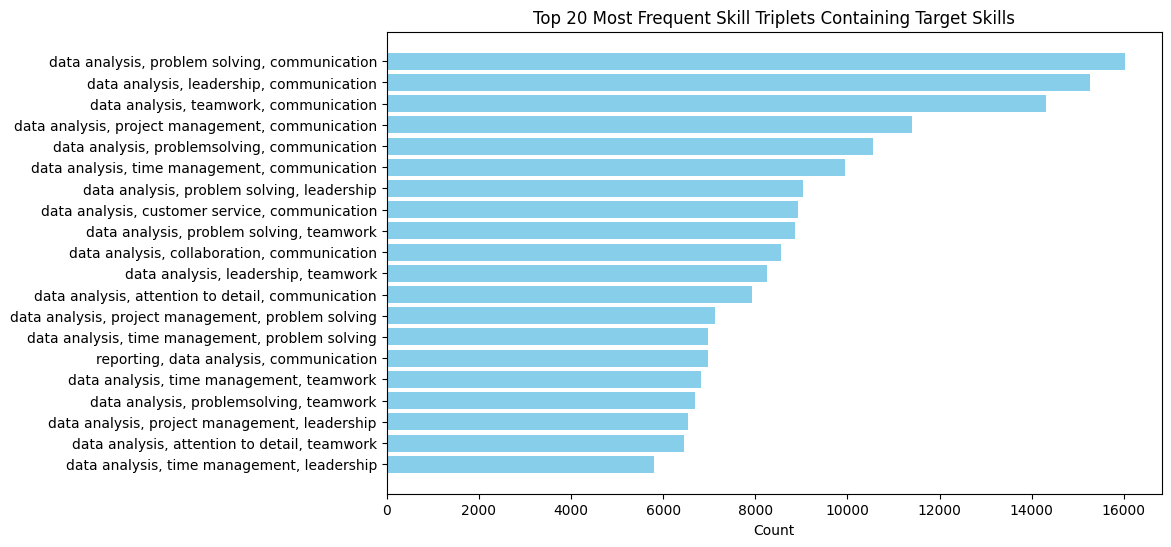

In [29]:
top_20_filtered_triplets_df = top_20_filtered_triplets.toPandas()
top_20_filtered_triplets_df["items"] = top_20_filtered_triplets_df["items"].apply(lambda x: ', '.join(x))

plt.figure(figsize=(10, 6))
plt.barh(top_20_filtered_triplets_df['items'], top_20_filtered_triplets_df['freq'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Most Frequent Skill Triplets Containing Target Skills')
plt.gca().invert_yaxis()
plt.show()

In [15]:
filtered_quadruplets = quadruplets.filter(expr(target_conditions))
top_20_filtered_quadruplets = filtered_quadruplets.orderBy(col("freq").desc()).limit(20)

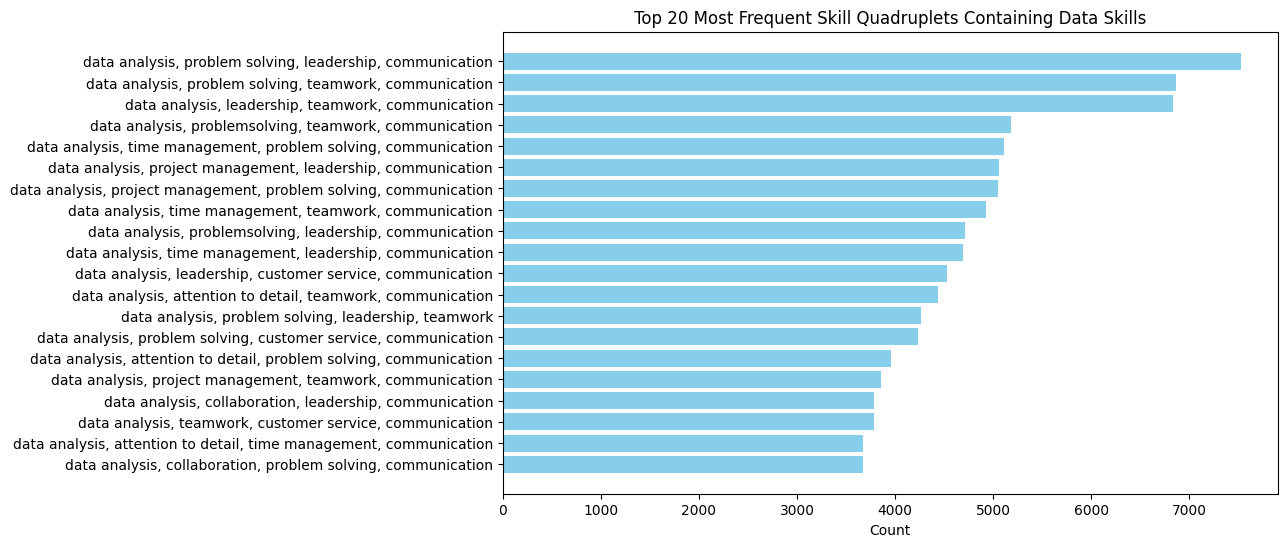

In [17]:
top_20_filtered_quadruplets_df = top_20_filtered_quadruplets.toPandas()
top_20_filtered_quadruplets_df["items"] = top_20_filtered_quadruplets_df["items"].apply(lambda x: ', '.join(x))

plt.figure(figsize=(10, 6))
plt.barh(top_20_filtered_quadruplets_df['items'], top_20_filtered_quadruplets_df['freq'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Most Frequent Skill Quadruplets Containing Data Skills')
plt.gca().invert_yaxis()
plt.show()

In [15]:
filtered_quintuplets = quintuplets.filter(expr(target_conditions))
top_20_filtered_quintuplets = filtered_quintuplets.orderBy(col("freq").desc()).limit(20)

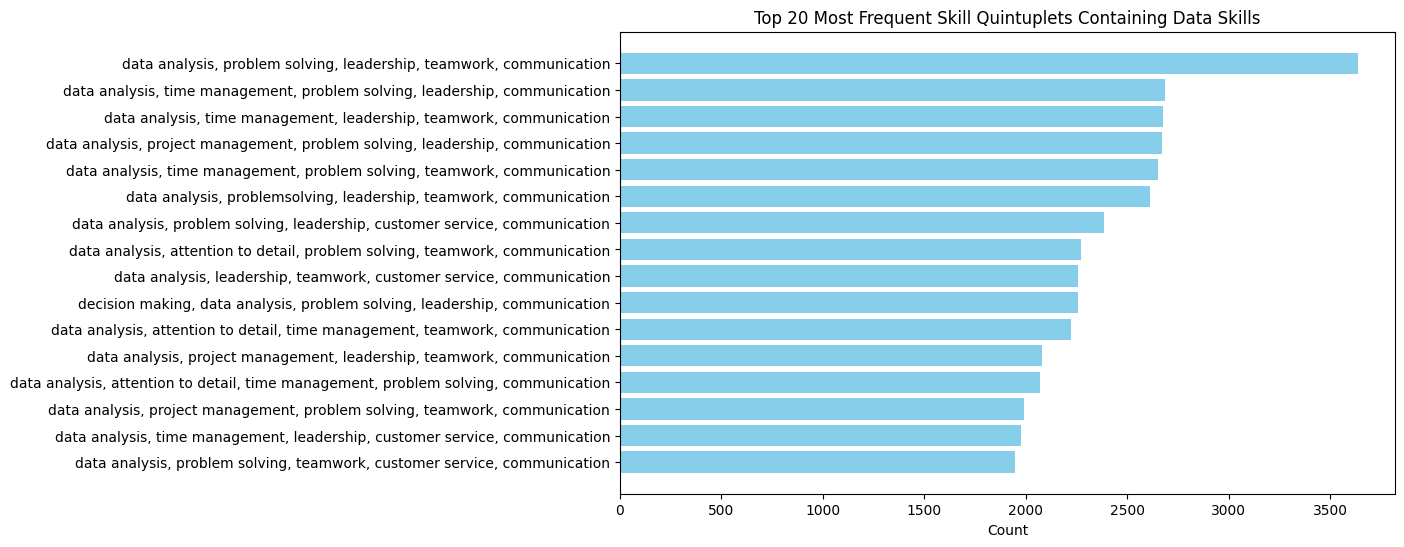

In [18]:
top_20_filtered_quintuplets_df = top_20_filtered_quintuplets.toPandas()
top_20_filtered_quintuplets_df["items"] = top_20_filtered_quintuplets_df["items"].apply(lambda x: ', '.join(x))

plt.figure(figsize=(10, 6))
plt.barh(top_20_filtered_quintuplets_df['items'], top_20_filtered_quintuplets_df['freq'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Most Frequent Skill Quintuplets Containing Data Skills')
plt.gca().invert_yaxis()
plt.show()

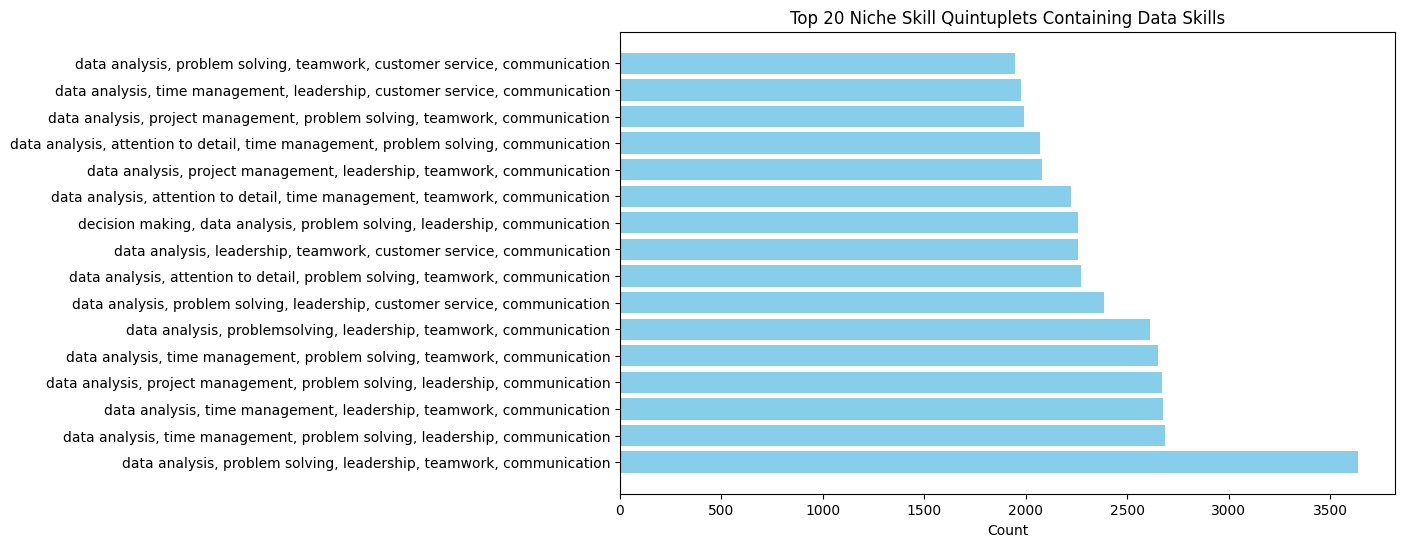

In [19]:
bottom_20_filtered_quintuplets = filtered_quintuplets.orderBy(col("freq").asc()).limit(20)
bottom_20_filtered_quintuplets_df = bottom_20_filtered_quintuplets.toPandas()
bottom_20_filtered_quintuplets_df["items"] = bottom_20_filtered_quintuplets_df["items"].apply(lambda x: ', '.join(x))

plt.figure(figsize=(10, 6))
plt.barh(bottom_20_filtered_quintuplets_df['items'], bottom_20_filtered_quintuplets_df['freq'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 20 Niche Skill Quintuplets Containing Data Skills')
plt.gca().invert_yaxis()
plt.show()